In [34]:
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from origami.forecast import construct_target
from origami.preprocess import merged_syst_n2ex
from origami.features import add_seasonal_features, normalise_feature_values, impute_missing
from origami.learn import get_scores, get_model, data_split
warnings.filterwarnings('ignore')

The following utility loads a joined DataFrame of system price/n2ex price.

When I work on notebooks, I tend to use them as sketch pads for utility functions which I collect into structured codebases.

In [35]:
cleaned_data = merged_syst_n2ex(
    syst_path='data/systems_prices.csv',
    n2ex_path='data/n2ex_da_2018.csv'
)

The utility below calculates a target variable with the following logic applied to each horizon time-window:

- if the price rose above the `positive_threshold` but did not fall below the negative, label `positive`
- if the price fell below the `negative_threshold` but did not rise above the positive, label `negative`
- if the price went past both thresholds, label `volatile`
- if the price did not go past either threshold, label `stable`
- otherwise label `unknown` (for nan cases in the data)

In this case, the thresholds are of +/-30%, and the look-ahead horizon is 6 periods (3 hours).

<AxesSubplot:>

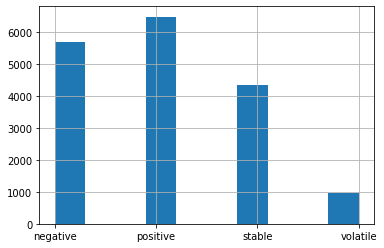

In [36]:
with_target = construct_target(
    cleaned_data,
    time_col='datetime',
    price_col='system_price',
    horizon_periods=6,
    positive_threshold=0.3,
    negative_threshold=-0.3
)
with_target['forecast'].hist()

The cells below add some simple seasonal features, normalise the data and impute missing values...

In [45]:
with_features, feature_names = add_seasonal_features(with_target, 'datetime')

In [46]:
features = ['system_price', 'n2ex_price', 'net_imbalance_volume', 'hour', 'dayofweek', 'month']
normalised = normalise_feature_values(with_features, features)
dataset = impute_missing(normalised, features)

In [47]:
dataset.head()

,datetime,net_imbalance_volume,system_price,n2ex_price,forecast,date,hour,dayofweek,month
0,2018-01-01 00:30:00,0.439344,0.180649,0.000000,negative,2018-01-01,0.000000,0.0,0.0
1,2018-01-01 01:00:00,0.469024,0.180649,0.208539,negative,2018-01-01,0.043478,0.0,0.0
2,2018-01-01 01:30:00,0.455782,0.186789,0.208539,negative,2018-01-01,0.043478,0.0,0.0
3,2018-01-01 02:00:00,0.397458,0.158772,0.249425,positive,2018-01-01,0.086957,0.0,0.0
4,2018-01-01 02:30:00,0.446756,0.184926,0.249425,stable,2018-01-01,0.086957,0.0,0.0


Now the learning evaluation procedure. I've done the following:

- Separate each month (excluding January) as a test dataset
- Treat all data before this test data as training data
- Learn, evaluate, and move onto the next month for testing

My reasoning is to have a simple backtesting procedure to see how the same pipeline on multiple re-fits. In reality, this isn't very realistic as you would probably re-fit models more than once a month (it is possible to change this setting with the `evaluation_time_window` parameter set to "D", but you'll need to fit a model for each day of the year!).

In terms of scoring the model, I give three scores:

- Macro-averaged AUC, which is a great baseline metric for the fundamental value of a classifier
- Precision of positive class, fixed to be 0.7 or higher
- Recall @ precision 0.7

My reasoning is that it is more useful to be precise than comprehensive when forecasting prices. It is ok to have no opinion a lot of the time, so long as your opinion is fairly likely to be correct when you have one.

The evaluator returns a DataFrame of results which I then plot and average for inspection.

In [48]:
def get_model():
    '''
    Just a simple model factory function, returning a balanced random forest classifier
    :return: RandomForestClassifier
    '''
    return RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced'
    )


def run_evaluation(
        dataset, feature_columns, target_column,
        time_column, evaluation_time_window='M', eval_start_time='2018-02-01',
        eval_end_time=None
):
    '''
    Training loop to back-test periods over a specific time window.
    :param dataset: DataFrame
    :param feature_columns: columns to treat as input features
    :param target_column: column to treat as prediction target
    :param time_column: time column
    :param evaluation_time_window: periods to evaluate over, e.g. 'M' or 'D'
    :param eval_start_time: where to start evaluating from
    :return: DataFrame of results
    '''
    results = []
    if eval_end_time is not None:
        dataset = dataset[dataset[time_column] <= eval_end_time]
    time_grouped = dataset \
        .set_index(time_column) \
        .groupby(pd.Grouper(freq=evaluation_time_window))
    eval_start_time = pd.to_datetime(eval_start_time)
    for test_period, test_data in time_grouped:
        min_test_date = test_data.index.min()
        if min_test_date >= eval_start_time:
            print('evaluating test period', test_period)
            train_data = dataset[dataset[time_column] < min_test_date]
            train_x, train_y, test_x, test_y = data_split(
                train_data,
                test_data,
                feature_columns=feature_columns,
                target_column=target_column
            )
            model = get_model().fit(train_x, train_y)
            probas = model.predict_proba(test_x)
            auc, pos_precision, pos_recall, pos_threshold = get_scores(
                probas,
                test_y,
                class_to_score='positive',
                class_ix=1,
                precision_threshold=0.7
            )
            results.append({
                'eval_period': test_period,
                'auc': auc,
                'precision': pos_precision,
                'recall': pos_recall,
                'threshold': pos_threshold
            })
    return pd.DataFrame(results)


evaluating test period 2018-02-28 00:00:00
evaluating test period 2018-03-31 00:00:00
evaluating test period 2018-04-30 00:00:00
evaluating test period 2018-05-31 00:00:00
evaluating test period 2018-06-30 00:00:00
evaluating test period 2018-07-31 00:00:00
evaluating test period 2018-08-31 00:00:00
evaluating test period 2018-09-30 00:00:00
evaluating test period 2018-10-31 00:00:00
evaluating test period 2018-11-30 00:00:00
evaluating test period 2018-12-31 00:00:00
Mean results: auc          0.714813
precision    0.703455
recall       0.371000
threshold    0.670455
dtype: float64


,eval_period,auc,precision,recall,threshold
0,2018-02-28,0.707378,0.704,0.309,0.685
1,2018-03-31,0.694298,0.702,0.353,0.650
2,2018-04-30,0.687720,0.702,0.216,0.760
3,2018-05-31,0.707704,0.724,0.093,0.800
4,2018-06-30,0.707474,0.701,0.428,0.660
5,2018-07-31,0.733319,0.700,0.826,0.455
6,2018-08-31,0.712276,0.701,0.370,0.680
7,2018-09-30,0.749477,0.700,0.643,0.510
8,2018-10-31,0.727817,0.702,0.262,0.705
9,2018-11-30,0.720698,0.701,0.228,0.800


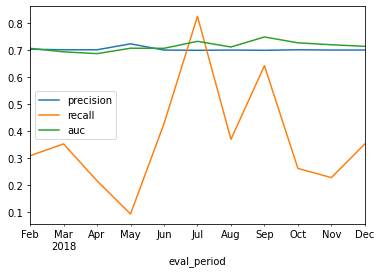

In [49]:
features = [
    'system_price', 'n2ex_price', 'net_imbalance_volume',
    'hour', 'dayofweek', 'month'
]
results = run_evaluation(
    dataset,
    feature_columns=features,
    target_column='forecast',
    time_column='datetime',
    evaluation_time_window='M',
    eval_end_time='2019-01-01'
)
results.set_index('eval_period')[['precision', 'recall', 'auc']].plot()
print('Mean results:', results.mean())
results

Although precision of 0.7 in a market price context sounds very good, I'm not sure this is particularly meaningful. On a horizon of 3 hours, you are probably likely to be correct for a good portion of the time just by knowing what time of day it is. It is probably more interesting to look at longer-term forecasts but more sophisticated modelling would be needed for that.

I would look next at time-series feature extraction for this. I did run some experimental time-series features using the `tsfresh` library, but didn't have time to develop it further.